For N anchors,

Given $(x_i, y_i, r_i)$ for $i \in {1...N}$ 

minimize $d$ subject to

$d \le \epsilon$

The distance should be greater or equal to the shortest distance to a path

For $I$ vertical paths $p_x$ and $J$ horizontal paths $p_y$

$d \ge (x-p_{x,i})b_i \quad \forall i \in I$

$d \ge (p_{x,i}-x)b_i \quad \forall i \in I$

$d \ge (y-p_{y,j})b_j \quad \forall j \in J$

$d \ge (p_{y,j}-y)b_j \quad \forall j \in J$

$\sum_{i=1}^Ib_i + \sum_{j=1}^Jb_j = 1$

$b_i\in{0,1} \quad \forall i \in I$
$b_j\in{0,1} \quad \forall j \in J$

$d, \epsilon, x, y \ge 0$

x and y should be in valid corridors, 

defined for $M$ vertical corridors $c_x$ by 2 $x$ coordinates $c_{x,m,s}$ and $c_{x,m,e} \forall m \in M$
where $c_{x,m,s} < c_{x,m,e}$

and for $N$ horizontal corridors $c_y$ by 2 $y$ coordinates $c_{y,n,s}$ and $c_{y,n,e} \forall n \in N$
where $c_{y,n,s} < c_{y,n,e}$

$x*b_m \ge c_{x,m,s}*b_m$

$x*b_m \le c_{x,m,e}*b_m$

$y*b_n \ge c_{y,n,s}*b_n$

$y*b_n \le c_{y,n,e}*b_n$

$1 \ge \sum^M_{m=0}b_m \ge 0$

$1 \ge \sum^N_{n=0}b_n \ge 0$

$2 \ge \sum^M_{m=0}b_m + \sum^N_{n=0}b_m \ge 1$

The Euclidean distance from $(x, y)$ to $(x_i, y_i)$ should be less than $j_i$

In [29]:
import pyomo.environ as pyo
import pandas as pd
import matplotlib.pyplot as plt

In [30]:
epsilon = 200

hor_paths = [300]
vert_paths = [1500, 2000]

hor_corridors = [[200, 400]]
vert_corridors = [[1400, 1600], [1900, 2100]]

anchors = [[100, 200], [400, 400], [700, 200]]

In [31]:
def find_pos(input_row):
    model = pyo.ConcreteModel()

    model.d = pyo.Var(domain=pyo.NonNegativeReals)

    model.error = pyo.Var(domain=pyo.NonNegativeReals)

    model.x = pyo.Var(domain=pyo.NonNegativeReals)
    model.y = pyo.Var(domain=pyo.NonNegativeReals)

    model.epsilon_constraint = pyo.Constraint(expr=model.d <= epsilon)

    # First Part

    model.I = pyo.Var(list(range(1, len(vert_paths) + 1)), domain=pyo.Binary)
    model.vert_path_cons = pyo.ConstraintList()
    for i, vp in enumerate(vert_paths):
        model.vert_path_cons.add(model.d >= (model.x - vp) * model.I[i+1])
        model.vert_path_cons.add(model.d >= (vp - model.x) * model.I[i+1])

    model.J = pyo.Var(range(1, len(hor_paths) + 1), domain=pyo.Binary)
    model.hor_path_cons = pyo.ConstraintList()
    for j, hp in enumerate(hor_paths):
        model.hor_path_cons.add(model.d >= (model.y - hp) * model.J[j+1])
        model.hor_path_cons.add(model.d >= (hp - model.y) * model.J[j+1])

    def path_constraint(model):
        return sum(model.I[i] for i in model.I) + sum(model.J[j] for j in model.J) == 1

    model.path_constraint = pyo.Constraint(rule=path_constraint)

    # Second Part

    model.N = pyo.Var(range(1, len(hor_corridors) + 1), domain=pyo.Binary)
    model.hor_corr_cons = pyo.ConstraintList()

    for n, hc in enumerate(hor_corridors):
        model.hor_corr_cons.add(model.y * model.N[n+1] >= hc[0] * model.N[n+1])
        model.hor_corr_cons.add(model.y * model.N[n+1] <= hc[1] * model.N[n+1])

    model.M = pyo.Var(range(1, len(vert_corridors) + 1), domain=pyo.Binary)
    model.vert_corr_cons = pyo.ConstraintList()

    for m, vc in enumerate(hor_corridors):
        model.vert_corr_cons.add(model.x * model.M[m+1]>= vc[0] * model.M[m+1])
        model.vert_corr_cons.add(model.x * model.M[m+1]<= vc[1] * model.M[m+1])

    model.hor_corr_cons.add(sum(model.N[n] for n in model.N) >= 0)
    model.hor_corr_cons.add(sum(model.N[n] for n in model.N) <= 1)

    model.vert_corr_cons.add(sum(model.M[m] for m in model.M) >= 0)
    model.vert_corr_cons.add(sum(model.M[m] for m in model.M) <= 1)

    model.corridor_constraints = pyo.ConstraintList()
    model.corridor_constraints.add(sum(model.M[m] for m in model.M) + sum(model.N[n] for n in model.N) >= 1)
    model.corridor_constraints.add(sum(model.M[m] for m in model.M) + sum(model.N[n] for n in model.N) <= 2)

    model.distance_constraints = pyo.ConstraintList()

    # Distance to Anchors (Minimise?)        

    def combined_objective(model):
        return abs((model.x - anchors[0][0])**2 + (model.y - anchors[0][1])**2- input_row[0]**2) + \
            abs((model.x - anchors[1][0])**2 + (model.y - anchors[1][1])**2- input_row[1]**2) + \
            abs((model.x - anchors[2][0])**2 + (model.y - anchors[2][1])**2- input_row[2]**2)

    model.obj = pyo.Objective(rule=combined_objective, sense=pyo.minimize)

    solver = pyo.SolverFactory('ipopt')
    solver.solve(model)

    return model.x.value, model.y.value

In [32]:
distances = pd.read_csv("distances.csv")

result_list = []

for i, row in distances.iterrows():
    inp = [row['anchor_1'], row['anchor_2'], row['anchor_3']]
    print(i)
    result_list.append(find_pos(inp))

0
model.name="unknown";
    - termination condition: infeasible
    - message from solver: Ipopt 3.14.14\x3a Converged to a locally infeasible
      point. Problem may be infeasible.
1
model.name="unknown";
    - termination condition: maxIterations
    - message from solver: Ipopt 3.14.14\x3a Maximum Number of Iterations
      Exceeded.
2


ValueError: Cannot load a SolverResults object with bad status: error

In [ ]:
df = pd.DataFrame(result_list, columns=['x', 'y'])

(200.0, 400.0)

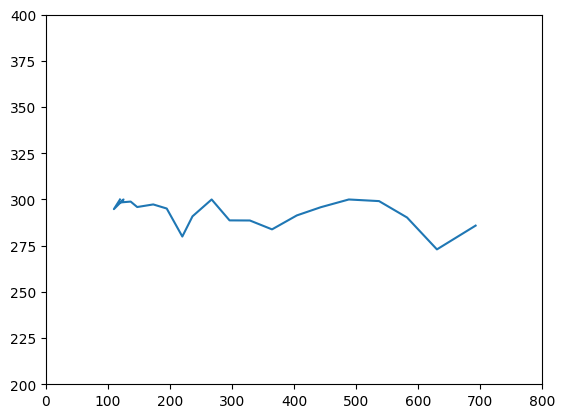

In [ ]:
plt.plot(df['x'], df['y'])
plt.xlim(0, 800)
plt.ylim(200, 400)
